In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

# 特征研究

In [2]:
data = pd.read_csv('../data/No-show-Issue-Comma-300k.csv')
print(len(data))
data.head()

300000


,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


打印每个特征集中不同值出现的频率

In [3]:
for column in list(data.columns):
    # {0:25}意味着第一个索引(即列)中的特征将被打印，并且将为其分配25个字符空间。
    # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量。用这个函数可以查看数据有多少个不同值。
    print("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
ApointmentData            534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


初始化函数绘制数据集中的所有特征

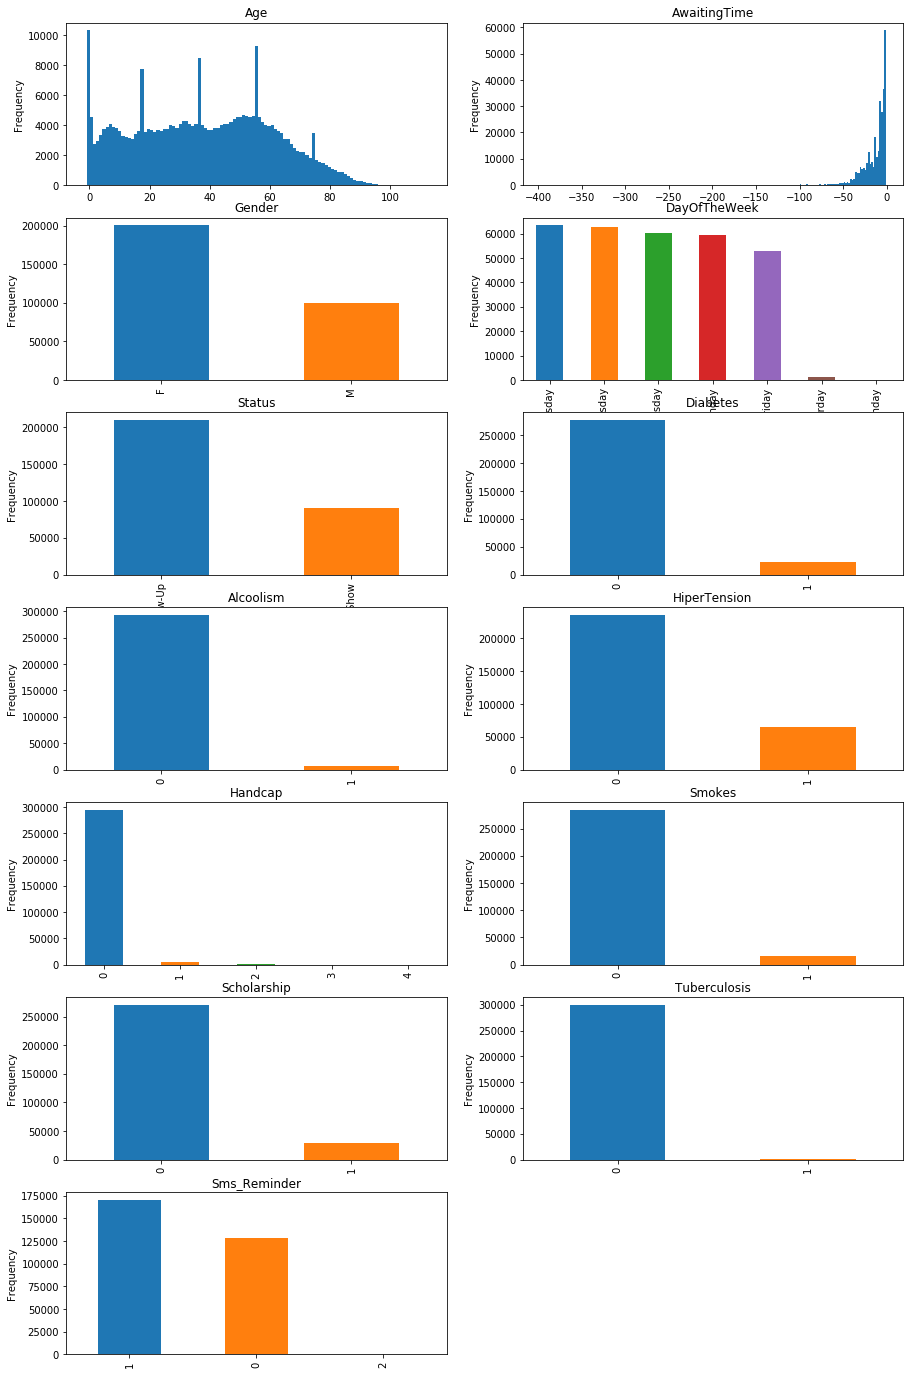

In [4]:
def features_plots(discrete_vars):
    plt.figure(figsize=(15, 24.5))
    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        # 这个参数指定bin(箱子)的个数,也就是总共有几条条状图
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')
    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism', 'HiperTension', 
                 'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

# 实施数据整理

数据清洗

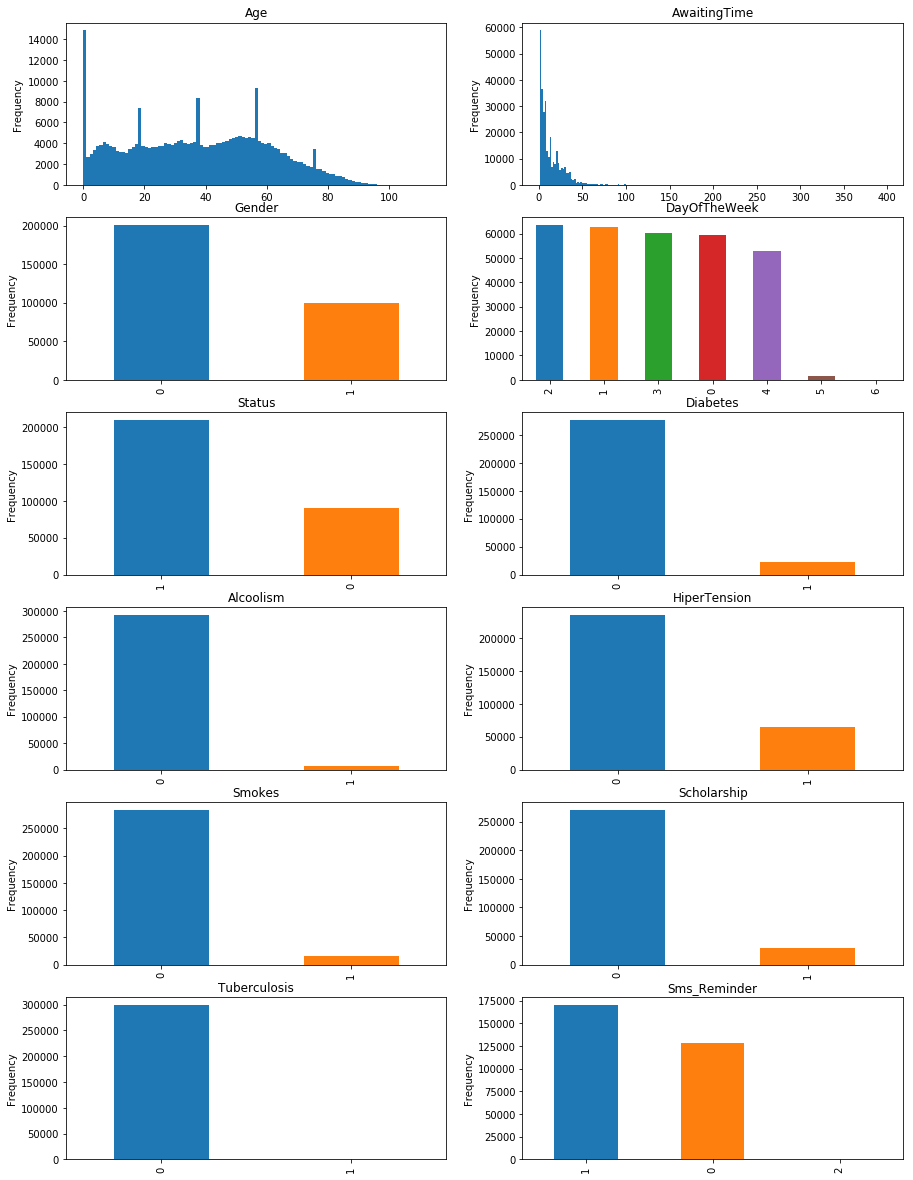

In [5]:
data[data['Age'] < 0]['Age'].value_counts().sum()
data = data[data['Age'] >= 0]
del data['Handcap']
data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))
dow_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)
for field in ['Gender', 'Status']:
    # pd.Categorical( list ).codes 这样就可以直接得到原始数据的对应的序号列表，通过这样的处理可以将类别信息转化成数值信息 
    data[field] = pd.Categorical(list(data[field])).codes
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism', 'HiperTension', 
                 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

# 实施探索性数据分析

(0, 120)

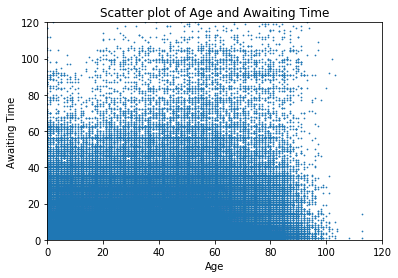

In [6]:
plt.scatter(data['Age'], data['AwaitingTime'], s=0.5)
plt.title('Scatter plot of Age and Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time')
plt.xlim(0, 120)
plt.ylim(0, 120)

In [7]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')
print(correlations)

                Age  AwaitingTime
Age           1.000        -0.004
AwaitingTime -0.004         1.000


短信提醒发送数量对状态的影响

Text(0,0.5,'Frequency')

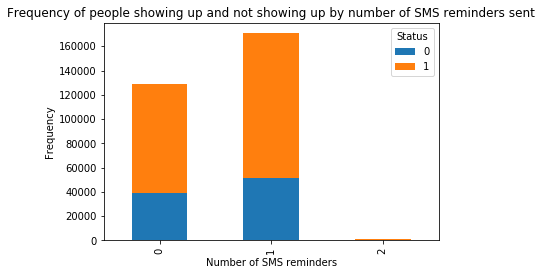

In [8]:
data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by number of SMS reminders sent')
plt.xlabel('Number of SMS reminders')
plt.ylabel('Frequency')

短信提醒数量对一周内预约日的影响

Text(0,0.5,'Frequency')

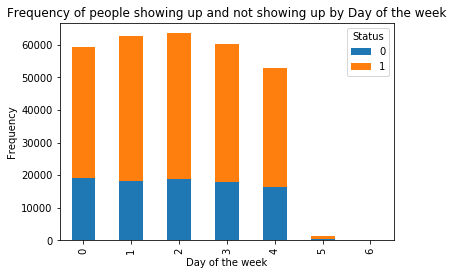

In [9]:
data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Frequency')

根据出现与否绘制病人年龄的箱形图

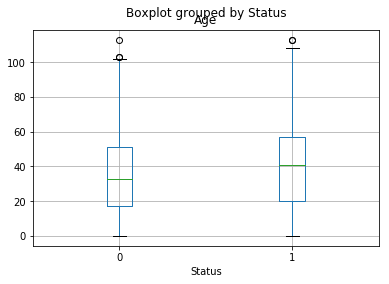

In [10]:
data.boxplot(column=['Age'], return_type='axes', by='Status')
plt.show()

针对患者出现与否，按性别绘制年龄曲线图

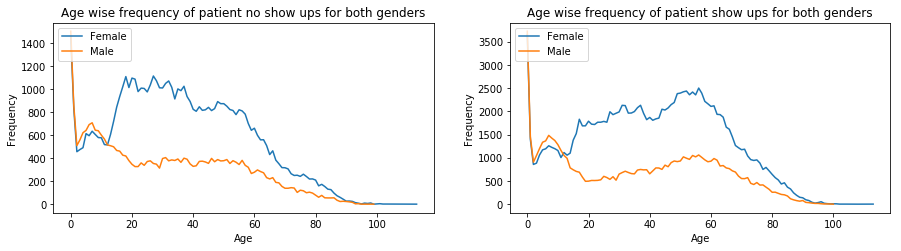

In [11]:
plt.figure(figsize=(15, 3.5))
for i, status in enumerate(['no show ups', 'show ups']):
    data_show = data[data['Status']==i]
    plt.subplot(1, 2, i+1)
    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender']==gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()
    plt.title('Age wise frequency of patient %s for both genders' % status)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend(['Female', 'Male'], loc='upper left')

根据出现与否绘制病人等待时间的箱形图

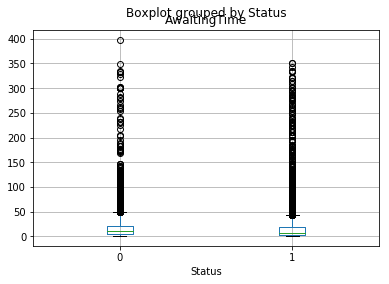

In [12]:
data.boxplot(column=['AwaitingTime'], return_type='axes', by='Status')
plt.show()

# 特征的生成

将时间分解为年/月/日/时/分/秒

In [13]:
for col in ['AppointmentRegistration', 'ApointmentData']:
    for index, component in enumerate(['year', 'month', 'day']):
        data['%s_%s' % (col, component)] = data[col].apply(lambda x: int(x.split('T')[0].split('-')[index]))
    for index, component in enumerate(['hour', 'min', 'sec']):
        data['%s_%s' % ('AppointmentRegistration', component)] = data['AppointmentRegistration'].apply(lambda x: int(x.split('T')[1][:-1].split(':')[index]))
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AwaitingTime,AppointmentRegistration_year,AppointmentRegistration_month,AppointmentRegistration_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec,ApointmentData_year,ApointmentData_month,ApointmentData_day
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,29,2014,12,16,14,46,25,2015,1,14
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,1,2015,8,18,7,1,26,2015,8,19
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,1,2014,2,17,12,53,46,2014,2,18
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,15,2014,7,23,17,2,11,2014,8,7
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,6,2015,10,21,15,20,9,2015,10,27


# 分类

In [14]:
def model_performance(model, model_name, X_train, y_train, y_test, Y_pred):
    print('Model name: %s' % model_name)
    # 分类准确率分数是指所有分类正确的百分比
    print('Test accuracy (Accuracy Score): %f' % metrics.accuracy_score(y_test, Y_pred))
    # 直接根据真实值（必须是二值）、预测值（可以是0/1,也可以是proba值）计算出auc值
    print('Test accuracy (ROC AUC Score): %f' % metrics.roc_auc_score(y_test, Y_pred))
    # 模型精度
    print('Train accuracy: %f' % model.score(X_train, y_train))
    # precision 、recall 、thresholds 
    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    # 计算AUC值，其中x,y分别为数组形式，根据(xi,yi)在坐标上的点，生成的曲线，然后计算AUC值
    print('Area Under the Precision-Recall Curve: %f' % metrics.auc(fpr, tpr))
    # 纵坐标：真正率/横坐标：假正率
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    # 绘制ROC_AUC曲线图
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [15]:
features_of_choice = ['Age', 'Gender', 'DayOfTheWeek', 'Diabetes', 'Alcoolism', 'HiperTension', 'Smokes', 'Scholarship', 'Tuberculosis',
                      'Sms_Reminder', 'AwaitingTime', 'AppointmentRegistration_year', 'AppointmentRegistration_month', 
                      'AppointmentRegistration_day', 'AppointmentRegistration_hour', 'AppointmentRegistration_min',
                      'AppointmentRegistration_sec', 'ApointmentData_year', 'ApointmentData_month','ApointmentData_day']
x = np.array(data[features_of_choice])
y = np.array(data['Status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## 决策树

In [16]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.588829
Test accuracy (ROC AUC Score): 0.523043
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.112398


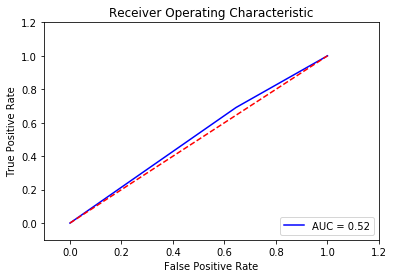

In [17]:
y_pred = clf.predict(x_test)
model_performance(clf, 'Decision tree classifier', x_train, y_train, y_test, y_pred)

## SGD分类器 

用核近似和SGD分类器训练模型

In [18]:
rbf_feature = kernel_approximation.RBFSampler(gamma=1, random_state=1)
X_train = rbf_feature.fit_transform(x_train)
clf = SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Model name: Kernel approximation
Test accuracy (Accuracy Score): 0.695619
Test accuracy (ROC AUC Score): 0.500000
Train accuracy: 0.698398
Area Under the Precision-Recall Curve: 0.152191


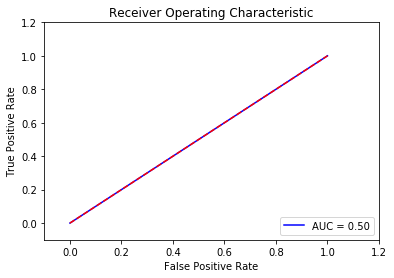

In [19]:
X_test = rbf_feature.fit_transform(x_test)
Y_pred = clf.predict(X_test)
model_performance(clf, 'Kernel approximation', X_train, y_train, y_test, Y_pred)

## 随机森林 

In [20]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Model name: Random Forest
Test accuracy (Accuracy Score): 0.639885
Test accuracy (ROC AUC Score): 0.533882
Train accuracy: 0.989971
Area Under the Precision-Recall Curve: 0.131635


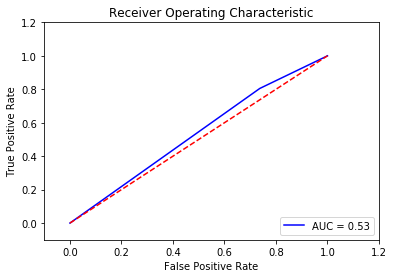

In [ ]:
y_pred = clf.predict(x_test)
model_performance(clf, 'Random Forest', x_train, y_train, y_test, y_pred)

## 梯度Boosting 

In [ ]:
clf = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=200, max_depth=5, max_features=10)
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)
model_performance(clf, 'Grandient Boosting', x_train, y_train, y_test, y_pred)

In [ ]:
for feature, score in zip(features_of_choice, list(clf.feature_importances_)):
    print('%s\t\t\t\t\t%f' % (feature, score))